In [9]:
from sklearn.gaussian_process import GaussianProcessRegressor
from scipy.stats import norm
from scipy.optimize import minimize
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [10]:
f7_inputs = np.load("initial_inputs.npy")
f7_outputs = np.load("initial_outputs.npy")
f7_inputs_2 = np.load("initial_inputs2.npy")
f7_outputs_2 = np.load("initial_outputs2.npy")

In [11]:
f7_inputs = np.concatenate((f7_inputs, f7_inputs_2)) 
f7_inputs = np.concatenate((f7_inputs, np.array([[0.63626 , 0.749201, 0.1892  , 0.68919 , 0.593918, 0.199029]]))) 
f7_inputs = np.concatenate((f7_inputs, np.array([[0.368718, 0.581611, 0.450298, 0.514296, 0.368287, 0.298886]]))) 
f7_inputs = np.concatenate((f7_inputs, np.array([[0.060895, 0.501672, 0.251022, 0.221018, 0.450428, 0.750969]]))) 
f7_inputs = np.concatenate((f7_inputs, np.array([[0.531569, 0.712456, 0.129994, 0.411075, 0.641262, 0.863832]]))) 
f7_inputs = np.concatenate((f7_inputs, np.array([[0.055673, 0.489451, 0.245211, 0.215896, 0.413761, 0.440428]])))
f7_inputs = np.concatenate((f7_inputs, np.array([[0.574342, 0.678895, 0.533896, 0.92418 , 0.554493, 0.523589]])))
f7_inputs = np.concatenate((f7_inputs, np.array([[0.100001, 0.495555, 0.297777, 0.198888, 0.396666, 0.693333]])))
f7_inputs = np.concatenate((f7_inputs, np.array([[0.088889, 0.493332, 0.282221, 0.205554, 0.403332, 0.695555]])))
f7_inputs = np.concatenate((f7_inputs, np.array([[0.097778, 0.497777, 0.299999, 0.192221, 0.385554, 0.713333]])))
f7_inputs = np.concatenate((f7_inputs, np.array([[0.699728, 0.60899 , 0.530807, 0.004961, 0.23617 , 0.606289]])))
f7_inputs = np.concatenate((f7_inputs, np.array([[0.189374, 0.254933, 0.38873 , 0.226883, 0.365509, 0.859723]])))
f7_inputs = np.concatenate((f7_inputs, np.array([[0.193819, 0.254933, 0.393174, 0.231327, 0.361065, 0.859723]])))
f7_inputs = np.concatenate((f7_inputs, np.array([[0.039062, 0.040611, 0.422165, 0.057258, 0.711931, 0.146917]])))
f7_inputs = np.concatenate((f7_inputs, np.array([[0.200485, 0.266044, 0.39984 , 0.237993, 0.354398, 0.848611]])))
f7_inputs = np.concatenate((f7_inputs, np.array([[0.211596, 0.286044, 0.410951, 0.249104, 0.343286, 0.828611]])))
f7_inputs = np.concatenate((f7_inputs, np.array([[0.222707, 0.306044, 0.422062, 0.260215, 0.332174, 0.808611]])))
f7_inputs = np.concatenate((f7_inputs, np.array([[0.229373, 0.321599, 0.428728, 0.266881, 0.325507, 0.793055]])))
f7_inputs = np.concatenate((f7_inputs, np.array([[0.222706, 0.337154, 0.422061, 0.264658, 0.327729, 0.777499]])))

f7_outputs = np.concatenate((f7_outputs,f7_outputs_2)) 
f7_outputs = np.append(f7_outputs,0.6531409333073234)
f7_outputs = np.append(f7_outputs,0.8720881396978204)
f7_outputs = np.append(f7_outputs,1.159982626521815)
f7_outputs = np.append(f7_outputs,0.06394964228046124)
f7_outputs = np.append(f7_outputs,0.9892232332511364)
f7_outputs = np.append(f7_outputs,0.02270238658904679)
f7_outputs = np.append(f7_outputs,1.5980696671819323)
f7_outputs = np.append(f7_outputs,1.552462506402468)
f7_outputs = np.append(f7_outputs,1.5958875261823084)
f7_outputs = np.append(f7_outputs,0.31095147109238114)
f7_outputs = np.append(f7_outputs,2.1108344344203425)
f7_outputs = np.append(f7_outputs,2.141437825123243)
f7_outputs = np.append(f7_outputs,0.14128327861643816)
f7_outputs = np.append(f7_outputs,2.2404023030732505)
f7_outputs = np.append(f7_outputs,2.3917589697962973)
f7_outputs = np.append(f7_outputs,2.5103520273309883)
f7_outputs = np.append(f7_outputs,2.57198926677023)
f7_outputs = np.append(f7_outputs,2.5936857026275053)



In [12]:
X_max= f7_inputs[np.argmax((f7_outputs))]
print(X_max)

[0.222706 0.337154 0.422061 0.264658 0.327729 0.777499]


In [13]:
Y_max= f7_outputs[np.argmax((f7_outputs))]
print(Y_max)

2.5936857026275053


In [6]:
def costly_function(x):
    total = np.array([])
    for x_i in x:
         total = np.append(total, np.sum(np.exp(-(x_i - 5) ** 2)))
    
    return total  + np.random.randn()

In [7]:
class BayesianOptimizer():
      
    def __init__(self, target_func, x_init, y_init, n_iter, scale, batch_size):
        self.x_init = x_init
        self.y_init = y_init
        self.target_func = target_func
        self.n_iter = n_iter
        self.scale = scale
        self.batch_size = batch_size
        self.gauss_pr = GaussianProcessRegressor()
        self.best_samples_ = pd.DataFrame(columns = ['x', 'y', 'ei'])
        self.distances_ = []
        
    def _get_expected_improvement(self, x_new):

        # Using estimate from Gaussian surrogate instead of actual function for 
        # a new trial data point to avoid cost 
 
        mean_y_new, sigma_y_new = self.gauss_pr.predict(np.array([x_new]), return_std=True)
        sigma_y_new = sigma_y_new.reshape(-1,1)
        if sigma_y_new == 0.0:
            return 0.0
        
        # Using estimates from Gaussian surrogate instead of actual function for 
        # entire prior distribution to avoid cost
        
        mean_y = self.gauss_pr.predict(self.x_init)
        max_mean_y = np.max(mean_y)
        z = (mean_y_new - max_mean_y) / sigma_y_new
        exp_imp = (mean_y_new - max_mean_y) * norm.cdf(z) + sigma_y_new * norm.pdf(z)
        
        return exp_imp
    def _acquisition_function(self, x):
        return -self._get_expected_improvement(x)
    
    def _get_next_probable_point(self):
            min_ei = float(sys.maxsize)
            x_optimal = None 
            
            # Trial with an array of random data points
            
            #for x_start in (np.random.random((self.batch_size,self.x_init.shape[1])) * self.scale):
            for x_start in np.random.uniform(low=0.1, high=0.99, size=(1,6)):
                response = minimize(fun=self._acquisition_function, x0=x_start, method='L-BFGS-B')
                if response.fun < min_ei:
                    min_ei = response.fun
                    x_optimal = response.x
            
            return x_optimal, min_ei
    def _extend_prior_with_posterior_data(self, x,y):
        self.x_init = np.append(self.x_init, np.array([x]), axis = 0)
        self.y_init = np.append(self.y_init, np.array(y), axis = 0)
        
    def optimize(self):
        y_max_ind = np.argmax(self.y_init)
        y_max = self.y_init[y_max_ind]
        optimal_x = self.x_init[y_max_ind]
        optimal_ei = None
        for i in range(self.n_iter):
            self.gauss_pr.fit(self.x_init, self.y_init)
            x_next, ei = self._get_next_probable_point()
            y_next = self.target_func(np.array([x_next]))
            self._extend_prior_with_posterior_data(x_next,y_next)
            
            if y_next[0] > y_max:
                y_max = y_next[0]
                optimal_x = x_next
                optimal_ei = ei

            if i == 0:
                 prev_x = x_next
            else:
                self.distances_.append(np.linalg.norm(prev_x - x_next))
                prev_x = x_next
            tmpdf = pd.DataFrame({"y": y_max, "ei": optimal_ei},index=[1])
            #self.best_samples_ = self.best_samples_.append({"y": y_max, "ei": optimal_ei},ignore_index=True)
            self.best_samples_ =pd.concat([self.best_samples_ ,tmpdf],ignore_index = True)
        
        return optimal_x, y_max
  
  
        

In [14]:
sample_x = f7_inputs
sample_y = f7_outputs

In [15]:
bopt = BayesianOptimizer(target_func=costly_function, x_init=sample_x, y_init=sample_y, n_iter=333, scale=7, batch_size=21)
bopt.optimize()

(array([0.83590681, 0.61603042, 0.95180015, 0.565072  , 0.86858319,
        0.94079502]),
 2.6534955650954637)

In [ ]:
#(array([0.53156942, 0.71245643, 0.1299946 , 0.41107594, 0.64126243,0.86383203]),3.3647573841577625)
#(array([0.82000932, 0.69085441, 0.97836447, 0.83643611, 0.45437705,0.66991839]),2.645454167297136)

In [25]:
f7_inputs

array([[0.27262382, 0.32449536, 0.89710881, 0.83295115, 0.15406269,
        0.79586362],
       [0.54300258, 0.9246939 , 0.34156746, 0.64648585, 0.71844033,
        0.34313266],
       [0.09083225, 0.66152938, 0.06593091, 0.25857701, 0.96345285,
        0.6402654 ],
       [0.11886697, 0.61505494, 0.90581639, 0.8553003 , 0.41363143,
        0.58523563],
       [0.63021764, 0.8380969 , 0.68001305, 0.73189509, 0.52673671,
        0.34842921],
       [0.76491917, 0.25588292, 0.60908422, 0.21807904, 0.32294277,
        0.09579366],
       [0.05789554, 0.49167222, 0.24742222, 0.21811844, 0.42042833,
        0.73096984],
       [0.19525188, 0.07922665, 0.55458046, 0.17056682, 0.01494418,
        0.10703171],
       [0.64230298, 0.83687455, 0.02179269, 0.10148801, 0.68307083,
        0.6924164 ],
       [0.78994255, 0.19554501, 0.57562333, 0.07365919, 0.25904917,
        0.05109986],
       [0.52849733, 0.45742436, 0.36009569, 0.36204551, 0.81689098,
        0.63747637],
       [0.72261522, 0

In [26]:
f7_outputs

array([6.04432696e-01, 5.62753067e-01, 7.50323668e-03, 6.14243025e-02,
       2.73046801e-01, 8.37465723e-02, 1.36496830e+00, 9.26449549e-02,
       1.78695987e-02, 3.35649360e-02, 7.35163042e-02, 2.06309698e-01,
       8.82563400e-03, 2.68400317e-01, 6.11525528e-01, 1.47981826e-02,
       2.74892508e-01, 6.67632469e-02, 4.21183545e-02, 2.70146502e-03,
       1.82090730e-02, 7.01602756e-03, 1.00506611e-01, 4.75395516e-01,
       6.75141631e-01, 5.16457219e-01, 3.77747962e-03, 3.13433331e-03,
       2.13425228e-02, 9.54111589e-02, 1.92262369e-02, 3.63302431e-01,
       5.54078747e-01, 5.03285693e-01, 3.78578840e-01, 3.51420597e-01,
       2.18384946e-02, 2.74181505e-03, 2.84503825e-03, 1.42061766e+00,
       4.00914794e-01, 7.63154709e-01, 5.41883328e-02, 1.48980895e+00,
       4.34444521e-01, 1.08014511e+00, 1.28917937e-01, 1.37702296e-01,
       1.83158802e-01, 4.76459379e-02, 3.76226779e-02, 1.27204165e-02,
       7.60433460e-02, 5.57235508e-02, 6.43550690e-02, 4.80363915e-02,
      

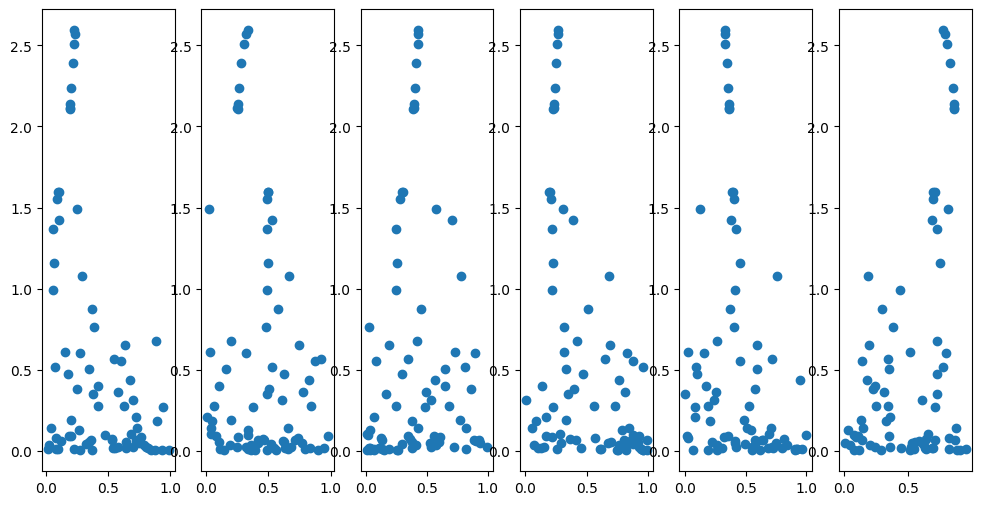

In [14]:
fig, ax = plt.subplots(1,6,figsize = (12,6))
ax[0].scatter(f7_inputs[:,0],f7_outputs)
ax[1].scatter(f7_inputs[:,1],f7_outputs)
ax[2].scatter(f7_inputs[:,2],f7_outputs)
ax[3].scatter(f7_inputs[:,3],f7_outputs)
ax[4].scatter(f7_inputs[:,4],f7_outputs)
ax[5].scatter(f7_inputs[:,5],f7_outputs)

plt.show()